In [10]:
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import xdem
from scipy import stats

## open data

In [2]:
data_path = '/mnt/Backups/gbrench/repos/rg_uavsar/data'

path_dic = {'swatch_00540':f'{data_path}/swatch_00540/geo',
            'swatch_08301':f'{data_path}/swatch_08301/geo',
            'swatch_09510':f'{data_path}/swatch_09510/geo',
            'swatch_17304_s1':f'{data_path}/swatch_17304_s1/geo',
            'swatch_17304_s2':f'{data_path}/swatch_17304_s2/geo',
            'swatch_18525':f'{data_path}/swatch_18525/geo',
            'swatch_26300':f'{data_path}/swatch_26300/geo',
            'swatch_27518':f'{data_path}/swatch_27518/geo'}

In [3]:
# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, engine='h5netcdf', phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

In [4]:
def open_uavsar(swatch, path):
    igram_ds = xr.open_dataset(f'{path}/{swatch}_20230725_20230925_unw_phase_m.tif').squeeze()
    cor_ds = xr.open_dataset(f'{path}/{swatch}_20230725_20230925_cor.tif').squeeze()
    geom_ds = mintpy2d_to_xarray(f'{path}/geo_geometryRadar.h5', crs='4326')
    geom_ds['cor'] = (('y', 'x'), cor_ds.band_data.values)
    geom_ds['displacement'] = (('y', 'x'), igram_ds.band_data.values)

    # reproject to utm
    geom_ds = geom_ds.rio.reproject('EPSG:32613', nodata=np.nan)

    # open rock glacier raster
    rgi_ds = xr.open_dataset(f'{data_path}/rgi_raster/rgi_raster.tif').squeeze()
    rgi_ds = rgi_ds.rio.reproject_match(geom_ds)

    geom_ds['rgi'] = (('y', 'x'), rgi_ds.band_data.values)
    
    return geom_ds

In [5]:
# open all data
ds_dic = {}
for key, item in path_dic.items():
    print(f'opening {key}')
    ds_dic[key] = open_uavsar(key, item)

opening swatch_00540
opening swatch_08301
opening swatch_09510
opening swatch_17304_s1
opening swatch_17304_s2
opening swatch_18525
opening swatch_26300
opening swatch_27518


In [5]:
# open reference points 
ref_dic = {}
for key, item in path_dic.items():
    print(f'opening {key}')
    # try:
    with open(f'{item}/correction_data.pkl', 'rb') as f:
        refs = pickle.load(f)
    ref_dic[key] = refs

opening swatch_00540
opening swatch_08301
opening swatch_09510
opening swatch_17304_s1
opening swatch_17304_s2
opening swatch_18525


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/Backups/gbrench/repos/rg_uavsar/data/swatch_18525/geo/correction_data.pkl'

## plot displacement / elevation relationships

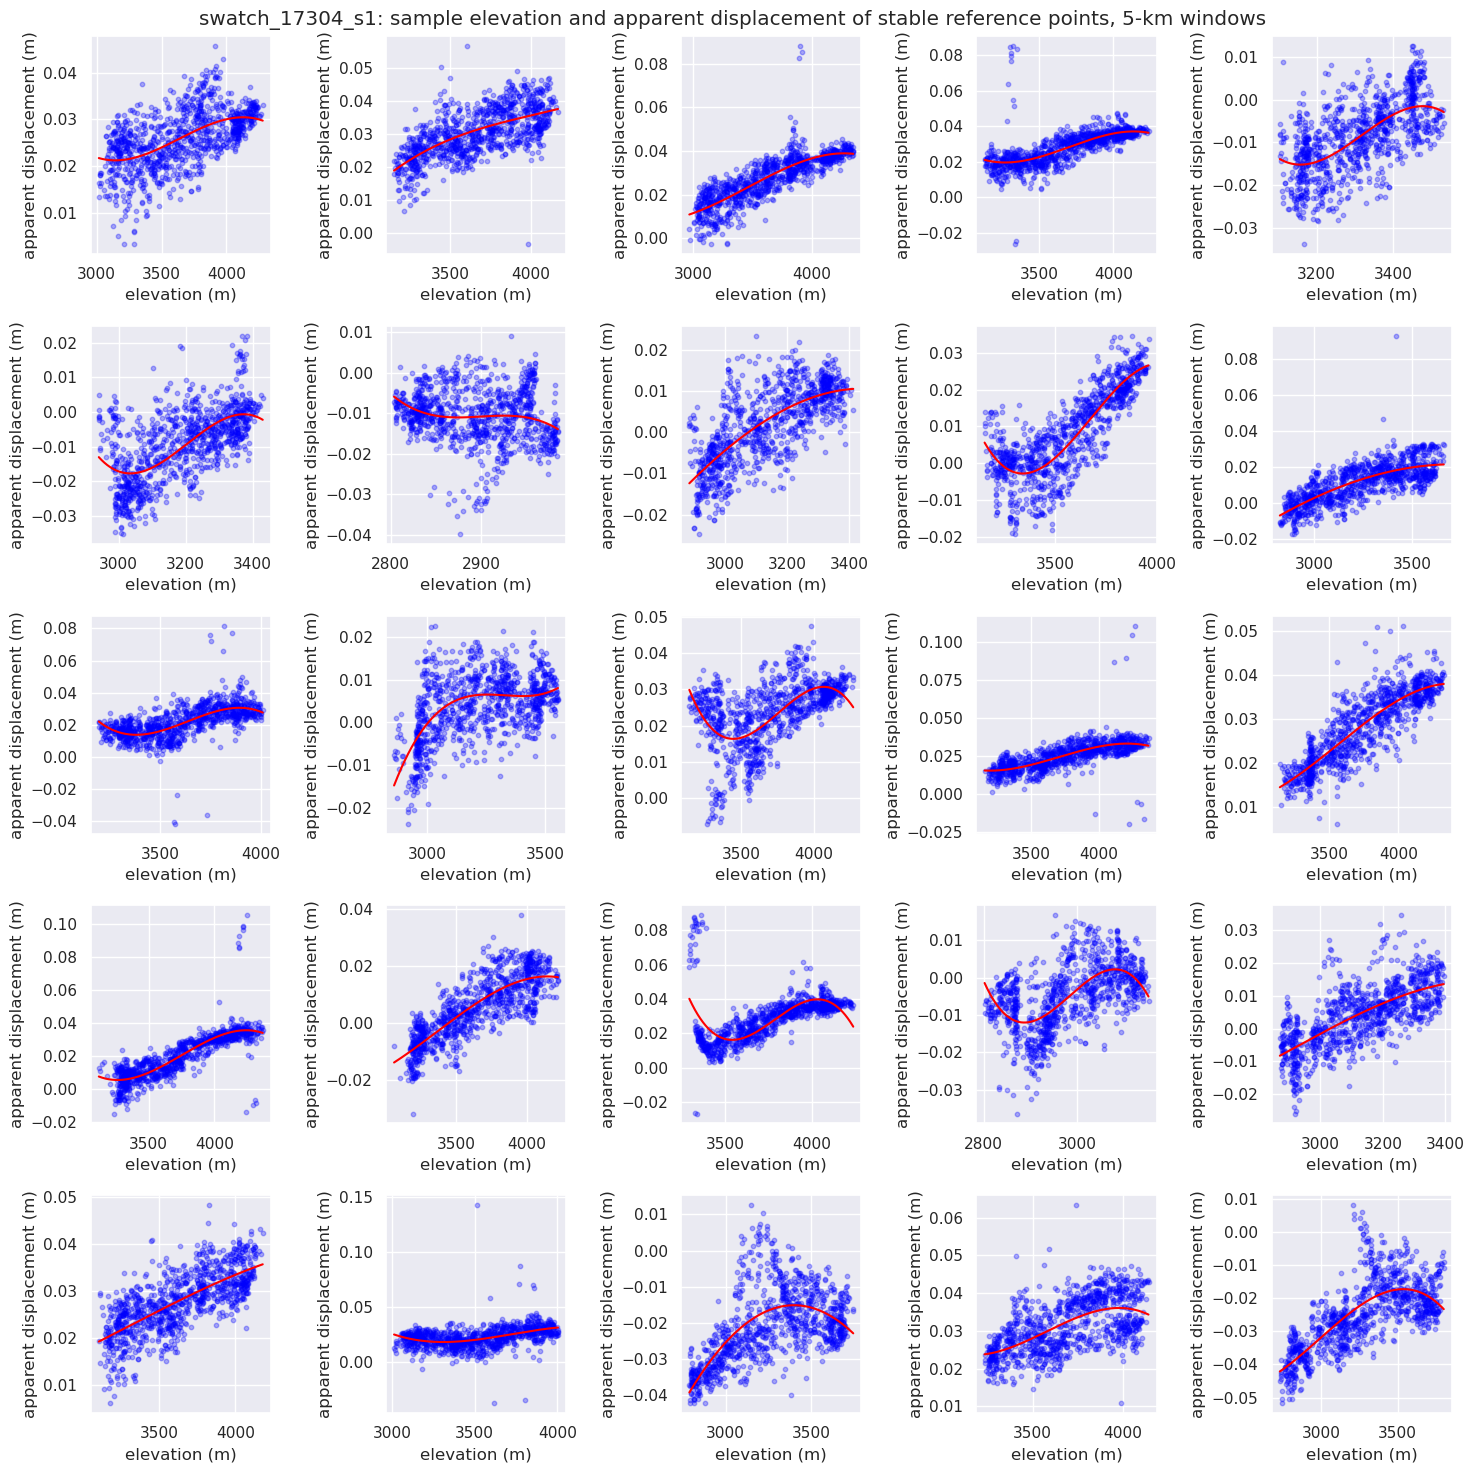

In [25]:
sns.set_theme()

# Generate 25 unique random indices from 0 to 168
indices = np.random.choice(range(len(ref_dic['swatch_17304_s1'])), 25, replace=False)

# Use these indices to select 25 lists
selected_data = [ref_dic['swatch_17304_s1'][i] for i in indices]

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    # Get the independent variable, dependent variable, and fit parameters
    y, x, fit_params = selected_data[i]

    # Plot the data as a scatter plot
    ax.scatter(x, y, s=10, color='blue', alpha=0.3)

    # Generate x values for the fit line
    x_fit = np.linspace(min(x), max(x), 1000)

    # Calculate the y values for the fit line
    y_fit = np.polyval(fit_params, x_fit)

    # Plot the fit line
    ax.plot(x_fit, y_fit, color='red')

    # Set the plot title
    ax.set_xlabel('elevation (m)')
    ax.set_ylabel('apparent displacement (m)')

# Display the plots
plt.suptitle('swatch_17304_s1: sample elevation and apparent displacement of stable reference points, 5-km windows')
plt.tight_layout()
plt.show()
fig.savefig(f'{path_dic["swatch_17304_s1"]}/figs/swatch_17304_s1_elevation_displacemnt_5km.png')

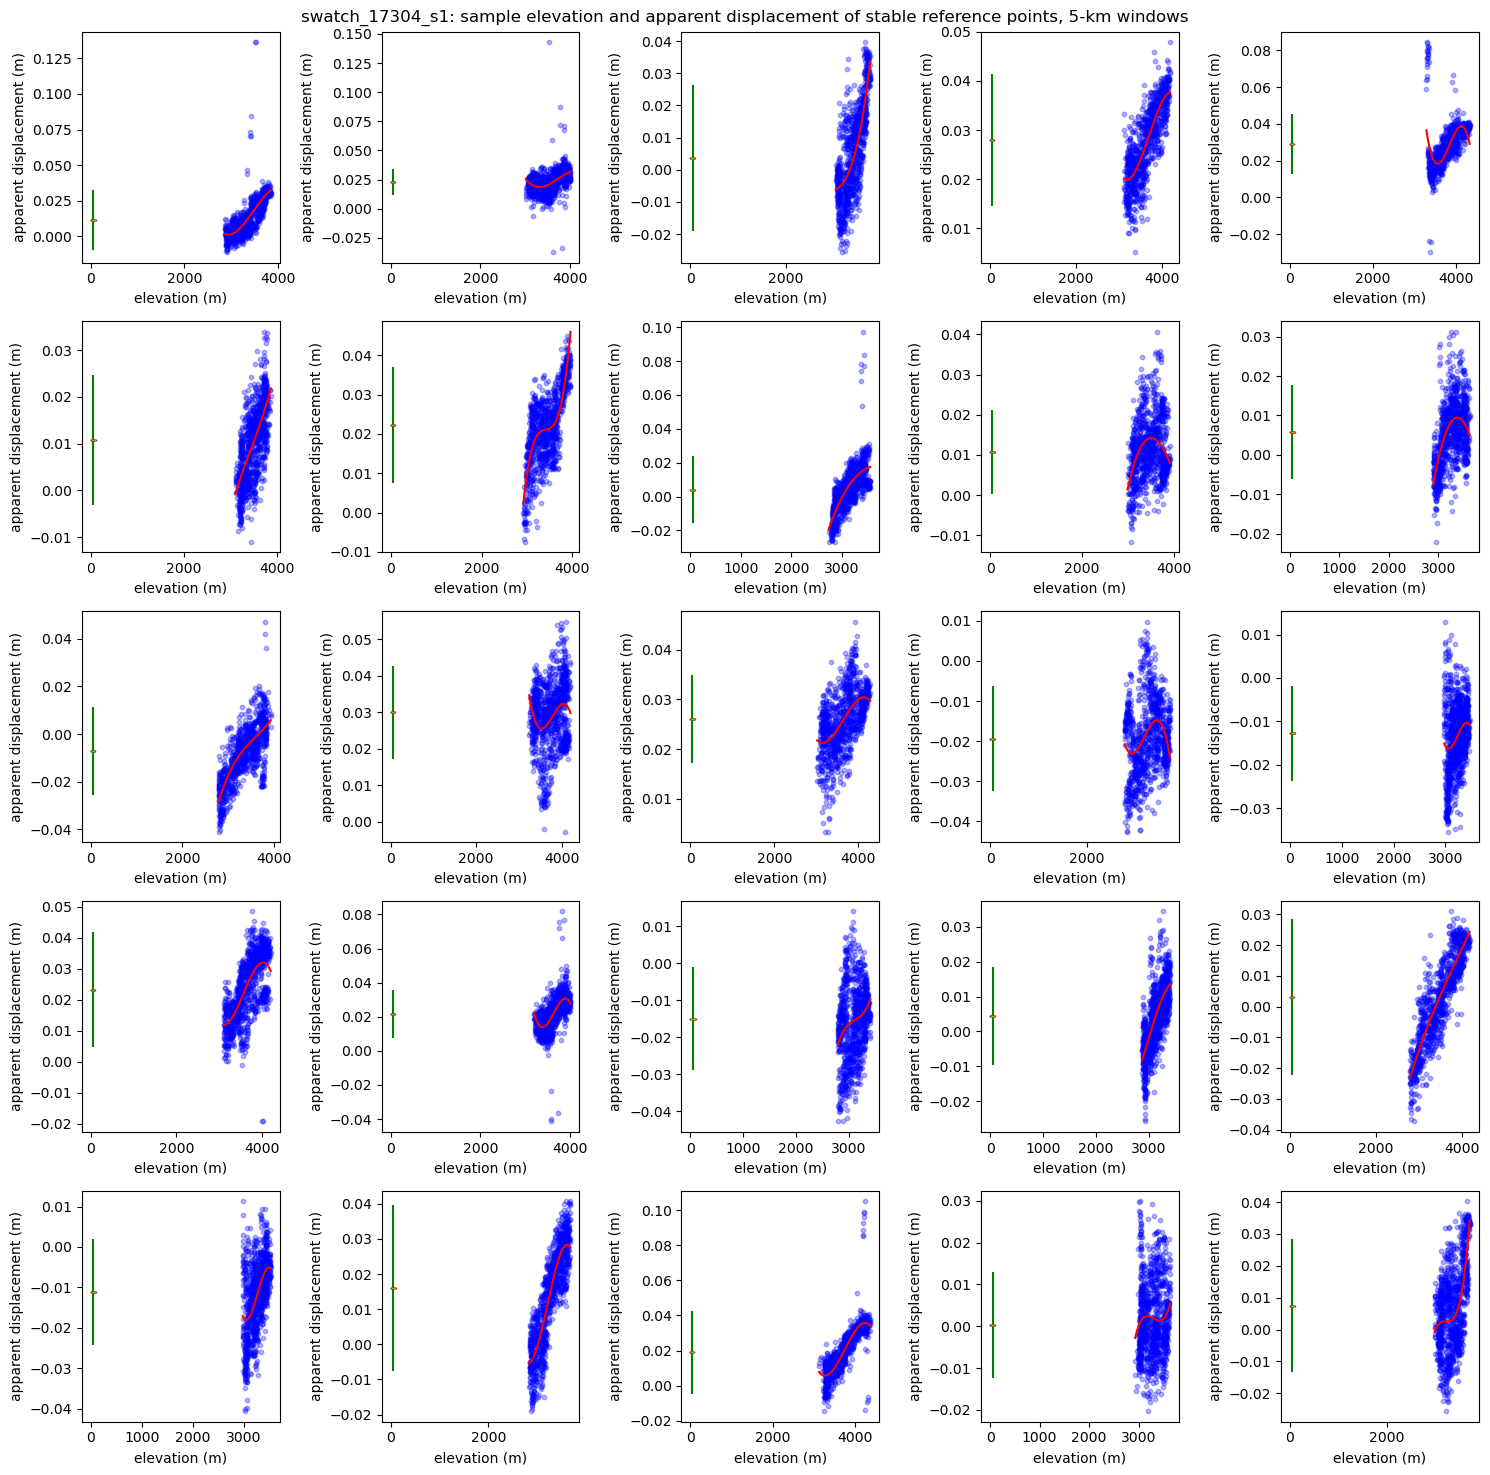

In [15]:
bin_width = 100

# function to calculate NMAD
def nmad(data):
    return 1.4826 * stats.median_abs_deviation(data, scale='normal')

# Generate 25 unique random indices from 0 to 168
indices = np.random.choice(range(len(ref_dic['swatch_17304_s1'])), 25, replace=False)

# Use these indices to select 25 lists
selected_data = [ref_dic['swatch_17304_s1'][i] for i in indices]

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Set bin_width to 100
bin_width = 100

for i, ax in enumerate(axs.flatten()):
    # Get the independent variable, dependent variable, and fit parameters
    y, x, fit_params = selected_data[i]

    # Convert y to a numpy array
    y = np.array(y)

    # Plot the data as a scatter plot
    ax.scatter(x, y, s=10, color='blue', alpha=0.3)

    # Generate x values for the fit line
    x_fit = np.linspace(min(x), max(x), 1000)

    # Calculate the y values for the fit line
    y_fit = np.polyval(fit_params, x_fit)

    # Plot the fit line
    ax.plot(x_fit, y_fit, color='red')

    # Compute the bin edges (you can adjust the number of bins as needed)
    bin_edges = np.arange(min(y), max(y) + bin_width, bin_width)

    # Compute the bin medians and NMADs
    bin_medians = [np.median(y[(y >= bin_edges[i]) & (y < bin_edges[i+1])]) for i in range(len(bin_edges)-1)]
    bin_nmads = [nmad(y[(y >= bin_edges[i]) & (y < bin_edges[i+1])]) for i in range(len(bin_edges)-1)]

    # Remove bins with NaN medians or nmads
    valid_bins = ~np.isnan(bin_medians) & ~np.isnan(bin_nmads)
    bin_medians = np.array(bin_medians)[valid_bins]
    bin_nmads = np.array(bin_nmads)[valid_bins]
    positions = bin_edges[:-1][valid_bins] + bin_width / 2

    # Plot the boxplots at the bin medians
    ax.boxplot(bin_medians, positions=positions, widths=np.diff(bin_edges), manage_ticks=False)

    # Plot the NMADs
    ax.errorbar(positions, bin_medians, yerr=bin_nmads, fmt='none', color='green')

    # Set the plot title
    ax.set_xlabel('elevation (m)')
    ax.set_ylabel('apparent displacement (m)')

# Display the plots
plt.suptitle('swatch_17304_s1: sample elevation and apparent displacement of stable reference points, 5-km windows')
plt.tight_layout()
plt.show()

## plot variograms

In [28]:
swatch = 'swatch_00540'
ds = ds_dic[swatch]

ds['displacement_masked'] = ds['displacement'].where(ds['rgi'] != 1)

In [31]:
df_vgm = xdem.spatialstats.sample_empirical_variogram(
    values=ds['displacement_masked'].values,
    gsd=5,
    subsample=1000,
    n_variograms=10,
    estimator="dowd",
    random_state=42,
)

/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ValueError: Residuals are not finite in the initial point.

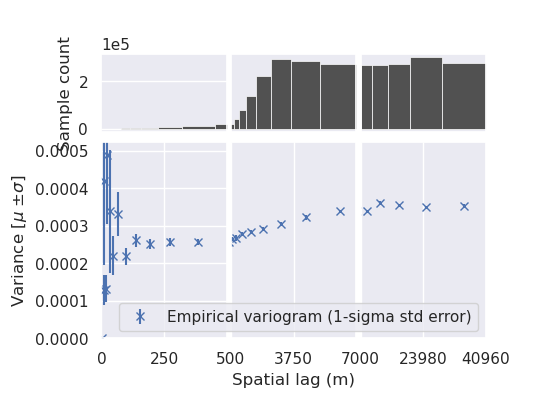

In [52]:
# func_sum_vgm, params_vgm = xdem.spatialstats.fit_sum_model_variogram(
#     ["Gaussian", "Spherical"], empirical_variogram=df_vgm
# )
xdem.spatialstats.plot_variogram(
    df_vgm,
    xscale_range_split=[500, 7000],
    # list_fit_fun=[func_sum_vgm],
    list_fit_fun_label=["Standardized double-range variogram"],
)

plt.savefig(f'{path_dic[swatch]}/figs/{swatch}_variogram')